# Тестовое задание на позицию Data Analyst - Бурый Артём
<div style="text-align: right"><a target="_blank" href="https://drive.google.com/file/d/14Hl1gFeVGPm1ChDI1HlNQB4Tz6bFH1Qd/view?usp=sharing">Резюме</a></div>
<div style="text-align: right"><a target="_blank" href="https://github.com/artsiom-bury/FRU_test_task/blob/main/FRU_test_task.ipynb">Ссылка на ipynb</a></div>

## Задание 1

Для начала подключим необходимые библиотеки, загрузим данные и посмотрим на них

In [157]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, shapiro

In [158]:
df = pd.read_csv('FRU_analytics_test_task.csv')
df

,ClientID,EventTime,EventType,DonationType,AmountInUSD,tag
0,885410877,2022-07-20 00:00:23,checkoutView,NaN,NaN,control
1,859319263,2022-07-20 00:00:48,checkoutView,NaN,NaN,test
2,480984859,2022-07-20 00:00:58,checkoutView,NaN,NaN,control
3,204664871,2022-07-20 00:01:00,checkoutView,NaN,NaN,test
4,859319263,2022-07-20 00:01:05,checkoutView,NaN,NaN,test
...,...,...,...,...,...,...
58765,244210529,2022-07-27 00:00:12,charge,one-time,62.0,NaN
58766,920234036,2022-07-27 00:02:47,charge,one-time,110.0,NaN
58767,450325260,2022-07-27 00:03:55,charge,one-time,32.0,NaN
58768,450325260,2022-07-27 00:04:09,checkoutView,NaN,NaN,control


Посмотрим подробнее на колонки

In [159]:
df[['ClientID', 'EventTime']].isna().sum()

ClientID     0
EventTime    0
dtype: int64

Нулевых значений по ID и дате нет

In [160]:
print(df['EventType'].value_counts())
print(df['DonationType'].value_counts())
print(df['tag'].value_counts())

checkoutView    53406
charge           5364
Name: EventType, dtype: int64
one-time     5189
recurring     175
Name: DonationType, dtype: int64
test       26764
control    26642
Name: tag, dtype: int64


Неожиданных значений тоже нет

In [161]:
df['AmountInUSD'].describe()

count     5364.000000
mean        78.335943
std        177.197650
min          5.000000
25%         20.000000
50%         50.000000
75%        106.000000
max      10000.000000
Name: AmountInUSD, dtype: float64

Здесь сразу видно, что есть выбросы. 75 квартиль 106, а максимальное значение 10000.

В качестве основной метрики для сравнения в АБ тесте, я бы выбрал среднее разовое пожертвование. Потому что именно на эту метрику больше всего должна повлиять наша доработка. Безусловно, если бы это был реальный рабочий кейс, то я бы проанализировал ещё конверсию в оплату (общую и раздельно в разовую и ежемесячную), количество оплат от одного пользователя. Но в рамках выполнения тестового остановлюсь на среднем разовом пожертвовании, чтобы уложиться в разумные сроки по времени выполнения.

Для этого оставим данные, где <code>'DonationType' == 'one-time'</code> и присоединим метки группы

In [162]:
df1 = df[(df['EventType']=='charge') & (df['DonationType']=='one-time')].drop(columns='tag').merge(df.dropna(subset='tag')[['ClientID', 'tag']].drop_duplicates(), how='left', on='ClientID')
df1

,ClientID,EventTime,EventType,DonationType,AmountInUSD,tag
0,204664871,2022-07-20 00:03:50,charge,one-time,200.0,test
1,480984859,2022-07-20 00:04:49,charge,one-time,110.0,control
2,204664871,2022-07-20 00:05:01,charge,one-time,28.0,test
3,162105910,2022-07-20 00:07:57,charge,one-time,50.0,control
4,768115744,2022-07-20 00:11:06,charge,one-time,10.0,test
...,...,...,...,...,...,...
5184,496846052,2022-07-27 00:00:04,charge,one-time,48.0,control
5185,244210529,2022-07-27 00:00:12,charge,one-time,62.0,control
5186,920234036,2022-07-27 00:02:47,charge,one-time,110.0,control
5187,450325260,2022-07-27 00:03:55,charge,one-time,32.0,control


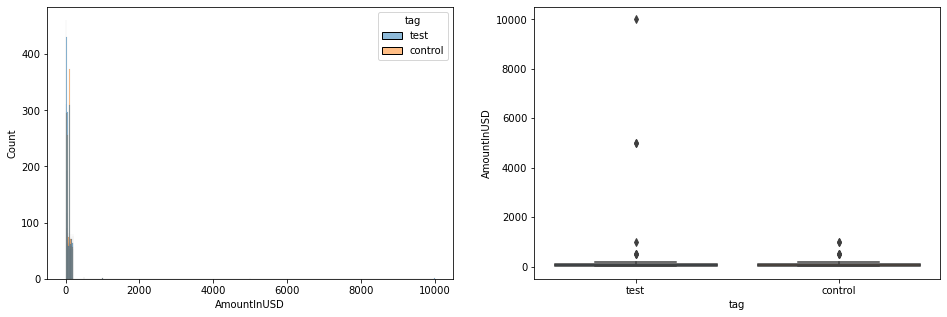

In [163]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
sns.histplot(data=df1, x="AmountInUSD", hue='tag', ax=axes[0])
sns.boxplot(data=df1, y="AmountInUSD", x='tag', ax=axes[1])
plt.show()

Здесь сразу видно, что надо убрать выбросы. Безусловно, пользователи, которые донатят по несколько тысяч долларов для нас важны. Но для АБ теста они крайне не показательны, и только смажут результаты. Все выбросы находятся в донатах выше 500 USD. Убрав их, получим красивые графики:

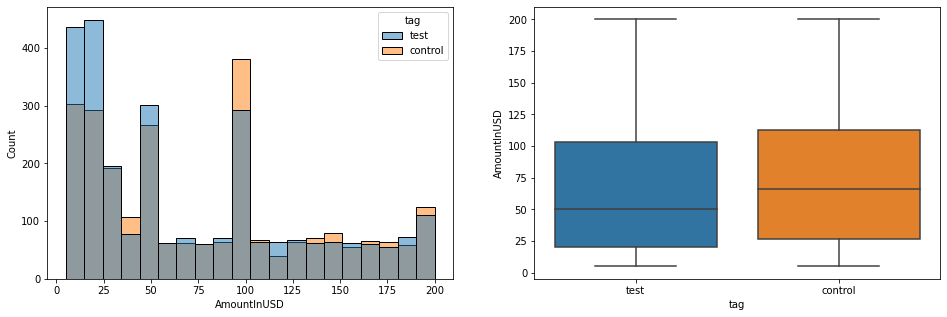

In [164]:
df1 = df1[df1['AmountInUSD'] < 500].copy()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
sns.histplot(data=df1, x="AmountInUSD", hue='tag', ax=axes[0])
sns.boxplot(data=df1, y="AmountInUSD", x='tag', ax=axes[1])
plt.show()

In [165]:
df1.groupby('tag').agg(
    unique_clients=('ClientID', 'nunique'), 
    count=('EventTime', 'count'),
    mean=('AmountInUSD', 'mean'),
    std=('AmountInUSD', 'std'))

,unique_clients,count,mean,std
tag,,,,
control,2349,2478,78.717514,57.557765
test,2578,2698,70.696442,57.699631


Тут уже сразу видно, что медианный средний донат у контрольной группы выше. Также видно без всяких критериев, что сами данные не распределены нормально (имеем много пользователей, которые выбирают один из возможных для выбора донатов, а не вписывают свою сумму). Но для применения t-критерия и не нужны нормально распределенные данные, нужно, чтобы статистика по этим данным (в нашем случае выборочное среднее) была распределено нормально. А так как данных у нас по ~ 2,5 тысячи, то в силу ЦПТ выборочное среднее будет распределено нормально. Но для успокоения совести можно это проверить

Результаты критерия Шапиро для контрольной группы: ShapiroResult(statistic=0.9975850582122803, pvalue=0.14872296154499054)
Результаты критерия Шапиро для контрольной группы: ShapiroResult(statistic=0.9966250658035278, pvalue=0.030689096078276634)


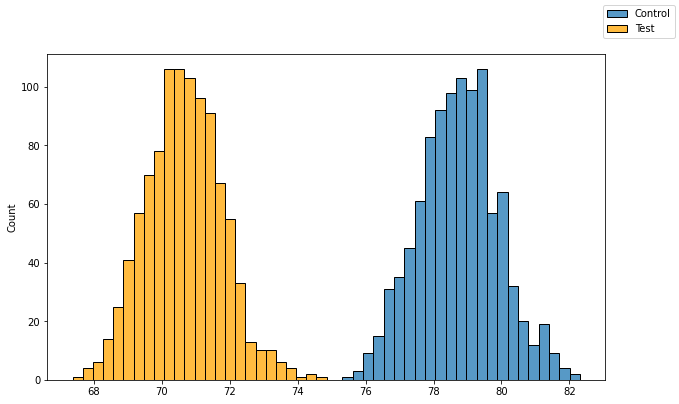

In [166]:
m_control, m_test = [], []
for i in range (1000):
    m_control.append(df1[df1['tag']=='control']['AmountInUSD'].sample(frac=1, replace=True).mean())
    m_test.append(df1[df1['tag']=='test']['AmountInUSD'].sample(frac=1, replace=True).mean())
print(f"Результаты критерия Шапиро для контрольной группы: {shapiro(m_control)}")
print(f"Результаты критерия Шапиро для контрольной группы: {shapiro(m_test)}")
fig = plt.figure(figsize=(10,6))
sns.histplot(m_control)
sns.histplot(m_test, color='orange')
fig.legend(labels=['Control','Test'])
plt.show()

В обоих случаях имеем pvalue > 0.05, значит нет оснований полагать, что данные не распределены нормально. Можно применять t-критерий. Выборки у нас независимые

In [167]:
ttest_ind(df1[df1['tag']=='control']['AmountInUSD'], df1[df1['tag']=='test']['AmountInUSD'])

Ttest_indResult(statistic=5.002015742435075, pvalue=5.860963652127546e-07)

pvalue << 0.05, а значит мы можем утверждать, что различие в средних для тестовой и контрольной выборок является статистически значимым, а вероятность ошибки первого рода у нас очень низкая.

## Вывод

То, что мы убрали предустановленный донат в 100$ статистически значимо негативно сказалось на среднем донате. Основываясь на данном критерии я не рекомендую принимать решение о внедрении этого изменения на всех пользователей. Однако, как я уже упоминал ранее, в реальной ситуации я бы посмотрел ещё на оставшиеся метрики, применил бы к ним соответствующие критерии (для конверсий был бы критерий хи-квадрат, а не стьюдента), и выдал бы общий вывод о том, стоит ли вводить изменение. Надеюсь, этого достаточно для оценки моих знаний по проведению АБ тестов.

# Задание 2

Компания UNICEF получает в среднем 200 пожертвований в день. Найдите вероятность
того, что за ближайшие полчаса в UNICEF сделают
1. ровно 5 пожертвований;
2. От 3 до 5 пожертвований;

## Решение

Это классический пример задачи на распределение Пуассона

$$
  P(k)=\frac{\lambda^k}{k!}e^{-\lambda},
$$
где $\lambda=np$.

В нашем случае $\lambda=\frac{200}{24 \cdot 2}$

Посчитаем значения на почти калькуляторе

In [172]:
def poisson(l,k):
    return (l ** k) / math.factorial(k) * (math.e ** (-l))

print(f'Вероятность ровно 5 пожертвований за полчаса: {poisson(200/48,5)}')
print(f'Вероятность от 3 до 5 пожертвований за полчаса: {poisson(200/48,3)+poisson(200/48,4)+poisson(200/48,5)}')

Вероятность ровно 5 пожертвований за полчаса: 0.1622565375330348
Вероятность от 3 до 5 пожертвований за полчаса: 0.5438839138107326


# Задание 3

Форма для совершения пожертвований состоит из нескольких отдельных экранов, на
каждом из которых у пользователя запрашивается различная информация (сумма
пожертвования, имя, электронный адрес и т.д.). Каждая организация может настроить форму под себя: 3 экрана являются обязательными для всех, а 2 других организация может включить или исключить из формы (как оба, так и любой из них). Таким образом, вся форма может состоять из 3,4 или 5 экранов. При этом первым в последовательности экранов всегда идет экран с выбором суммы. Все следующие экраны могут идти в любой последовательности. Определите, какое количество уникальных флоу (последовательностей экранов) доступно организациям.

## Решение

Задача на комбинаторику. Сразу можно забыть про первый экран: он есть всегда, и он всегда на первом месте. Ответ - это количество комбинаций из 2 экранов + (количеством комбинаций из 3 экранов) * 2 + количество комбинаций из 4 экранов. Умножаем второе слагаемое на двойку, так как можем выбрать один из двух опциональных экранов.

$N = A_2^2 + A_3^3 * 2 + A_4^4$

In [169]:
from scipy.special import perm

perm(2,2) + perm(3,3)*2 + perm(4,4)

38.0

# Задание 4

Код пишу для PostgreSQL

```sql
with t2 as (
	with t1 as (
	    select to_char(we.EventTime, 'YYYY-MM-DD') as Event_date,
	        we.ClientID,
	        count(*)
	    from websites_events we
	    where we.EventType = 'elementView'
	    group by to_char(we.EventTime, 'YYYY-MM-DD'),
	        we.ClientID
	)
    select c.Event_date,
        c.ClientID,
        c.Campaign_key
    from charges c
    left join (select c1.Campaign_key,
                    max(c1.AmountInUSD) as max_amount
                from charges c1
                left join t1 on (to_char(c1.Event_date, 'YYYY-MM-DD') = t1.Event_date and
                    c1.ClientID = t1.ClientID)
                where t1.count is null
                group by c1.Campaign_key) c2 on c2.Campaign_key = c.Campaign_key
    where c.AmountInUSD = c2.max_amount
)
select w.campaign_name ,
	t2.Event_date,
	t2.ClientID
from widgets w
left join t2 on t2.Campaign_key = w.Campaign_key
where w.Company_name <> 'My_company'
```